### Required Try-It Activity 14.1: Grid Searching Decision Trees 

This try-it focuses on performing a grid search with a `DecisionTreeClassifier`.  As mentioned in the lectures, the grid search for a tree model can get large very easily. In addition to using `GridSearchCV`, scikitlearn implements additional tools that can save energy and offer alternatives to the brute force exhaustive search.  Below, you will compare the performance of some of these alternatives and discuss the time these searches take.  Note that this will be in large part determined by your personal computing power however the relative speed of the searches should be consistent.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV,
                                     HalvingGridSearchCV, HalvingRandomSearchCV)
from sklearn.tree import DecisionTreeClassifier
import time

### Comparing Grid Searches

Below, explore the four grid search options using the same parameter selections for the `DecisionTreeClassifier`. All of the grid searching tools have a `.cv_results_` attribute after fitting that contains information after fitting including time.  Use this to compare the time of each search and discuss what you believe the "best" approach to identifying the hyperparameters of the model are between:

- `GridSearchCV`
- `RandomizedSearchCV`
- `HalvingGridSearchCV`
- `HalvingRandomSearchCV`

Share your results in a plot comparing the different times for searching across the different parameters as well as the score of the different estimators that resulted from the grid search.  

In [2]:
# Load data
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("🔍 Comparing All 4 Grid Search Methods")
print("Dataset size:", X_train.shape)


🔍 Comparing All 4 Grid Search Methods
Dataset size: (455, 30)


In [3]:
# Parameter grid
params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'criterion': ['gini', 'entropy']
}

total_combinations = np.prod([len(v) for v in params.values()])
print(f"Total parameter combinations: {total_combinations}")



Total parameter combinations: 24


In [4]:
# Initialize results storage
results = {}

In [5]:
# Method 1: GridSearchCV - Tests ALL combinations
print("\n1️⃣ GridSearchCV - Tests ALL combinations")
start = time.time()
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42), 
    params, 
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
grid_time = time.time() - start

results['GridSearchCV'] = {
    'Time': grid_time,
    'Score': grid_search.best_score_,
    'Params': grid_search.best_params_,
    'Total_Fits': len(grid_search.cv_results_['params'])
}

print(f"   ⏱️ Time: {grid_time:.2f} seconds")
print(f"   🎯 Best score: {grid_search.best_score_:.4f}")
print(f"   📊 Tested: {len(grid_search.cv_results_['params'])} combinations")



1️⃣ GridSearchCV - Tests ALL combinations
   ⏱️ Time: 3.08 seconds
   🎯 Best score: 0.9384
   📊 Tested: 24 combinations


In [6]:
# Method 2: RandomizedSearchCV - Tests random sample
print("\n2️⃣ RandomizedSearchCV - Tests RANDOM sample")
start = time.time()
random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42), 
    params, 
    n_iter=15,  # Test 15 random combinations
    cv=3, 
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
random_time = time.time() - start

results['RandomizedSearchCV'] = {
    'Time': random_time,
    'Score': random_search.best_score_,
    'Params': random_search.best_params_,
    'Total_Fits': len(random_search.cv_results_['params'])
}

print(f"   ⏱️ Time: {random_time:.2f} seconds")
print(f"   🎯 Best score: {random_search.best_score_:.4f}")
print(f"   📊 Tested: {len(random_search.cv_results_['params'])} combinations")




2️⃣ RandomizedSearchCV - Tests RANDOM sample
   ⏱️ Time: 0.07 seconds
   🎯 Best score: 0.9384
   📊 Tested: 15 combinations


In [7]:
# Method 3: HalvingGridSearchCV - Iteratively eliminates poor performers
print("\n3️⃣ HalvingGridSearchCV - ELIMINATES poor performers")
start = time.time()
halving_grid_search = HalvingGridSearchCV(
    DecisionTreeClassifier(random_state=42),
    params,
    cv=3,
    random_state=42,
    n_jobs=-1
)
halving_grid_search.fit(X_train, y_train)
halving_grid_time = time.time() - start

results['HalvingGridSearchCV'] = {
    'Time': halving_grid_time,
    'Score': halving_grid_search.best_score_,
    'Params': halving_grid_search.best_params_,
    'Total_Fits': len(halving_grid_search.cv_results_['params'])
}

print(f"   ⏱️ Time: {halving_grid_time:.2f} seconds")
print(f"   🎯 Best score: {halving_grid_search.best_score_:.4f}")
print(f"   📊 Tested: {len(halving_grid_search.cv_results_['params'])} combinations")




3️⃣ HalvingGridSearchCV - ELIMINATES poor performers
   ⏱️ Time: 0.10 seconds
   🎯 Best score: 0.9332
   📊 Tested: 35 combinations


In [8]:
# Method 4: HalvingRandomSearchCV - Random + halving strategy
print("\n4️⃣ HalvingRandomSearchCV - RANDOM + halving")
start = time.time()
halving_random_search = HalvingRandomSearchCV(
    DecisionTreeClassifier(random_state=42),
    params,
    cv=3,
    random_state=42,
    n_jobs=-1
)
halving_random_search.fit(X_train, y_train)
halving_random_time = time.time() - start

results['HalvingRandomSearchCV'] = {
    'Time': halving_random_time,
    'Score': halving_random_search.best_score_,
    'Params': halving_random_search.best_params_,
    'Total_Fits': len(halving_random_search.cv_results_['params'])
}

print(f"   ⏱️ Time: {halving_random_time:.2f} seconds")
print(f"   🎯 Best score: {halving_random_search.best_score_:.4f}")
print(f"   📊 Tested: {len(halving_random_search.cv_results_['params'])} combinations")




4️⃣ HalvingRandomSearchCV - RANDOM + halving


   ⏱️ Time: 0.12 seconds
   🎯 Best score: 0.9720
   📊 Tested: 35 combinations


/opt/miniconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=37. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


/var/folders/nc/j5wgj7050jg04tv1f8lb221w0000gn/T/ipykernel_51745/1425445788.py:51: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nc/j5wgj7050jg04tv1f8lb221w0000gn/T/ipykernel_51745/1425445788.py:51: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nc/j5wgj7050jg04tv1f8lb221w0000gn/T/ipykernel_51745/1425445788.py:51: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:

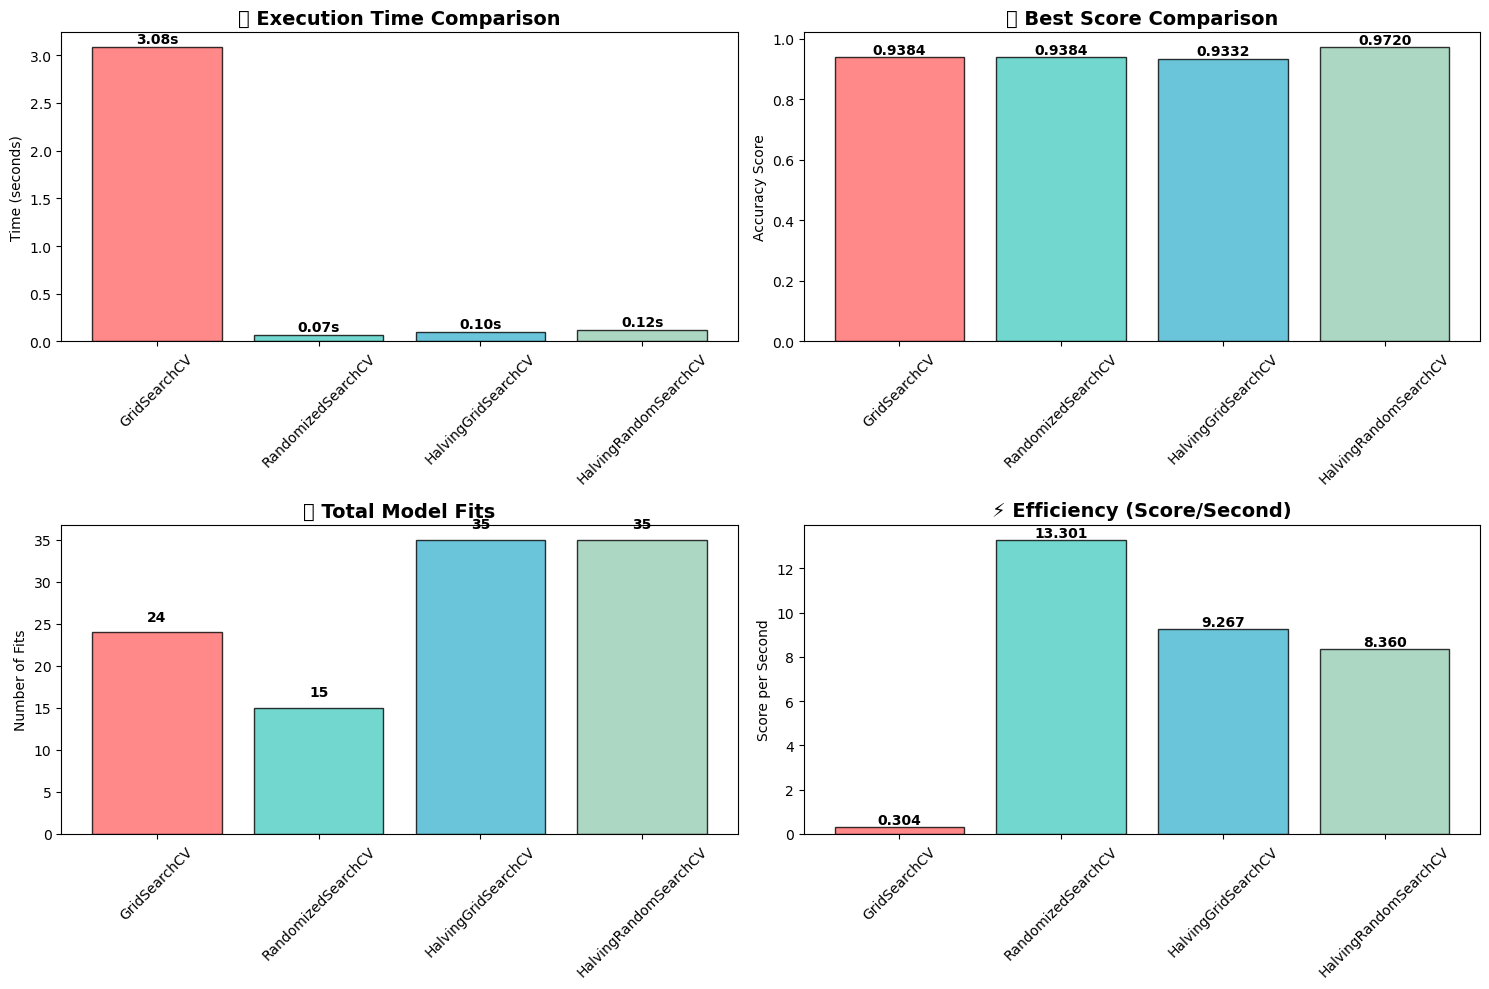

In [ ]:
# Create comparison visualization
methods = list(results.keys())
times = [results[method]['Time'] for method in methods]
scores = [results[method]['Score'] for method in methods]
total_fits = [results[method]['Total_Fits'] for method in methods]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# 1. Time Comparison
bars1 = ax1.bar(methods, times, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('⏱️ Execution Time Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Time (seconds)')
ax1.tick_params(axis='x', rotation=45)
for bar, time_val in zip(bars1, times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')
    
# 2. Best Score Comparison
bars2 = ax2.bar(methods, scores, color=colors, alpha=0.8, edgecolor='black')
ax2.set_title('🎯 Best Score Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Accuracy Score')
ax2.tick_params(axis='x', rotation=45)
for bar, score in zip(bars2, scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
    
# 3. Total Fits Comparison
bars3 = ax3.bar(methods, total_fits, color=colors, alpha=0.8, edgecolor='black')
ax3.set_title('📊 Total Model Fits', fontsize=14, fontweight='bold')
ax3.set_ylabel('Number of Fits')
ax3.tick_params(axis='x', rotation=45)
for bar, fits in zip(bars3, total_fits):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{fits}', ha='center', va='bottom', fontweight='bold')
    
# 4. Efficiency (Score per Second)
efficiency = [score/time_val for score, time_val in zip(scores, times)]
bars4 = ax4.bar(methods, efficiency, color=colors, alpha=0.8, edgecolor='black')
ax4.set_title('⚡ Efficiency (Score/Second)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Score per Second')
ax4.tick_params(axis='x', rotation=45)
for bar, eff in zip(bars4, efficiency):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{eff:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('images/search_comparison.jpg', dpi=300, bbox_inches='tight')
plt.show()    

In [10]:
# Results summary table
results_df = pd.DataFrame(results).T
results_df['Efficiency'] = results_df['Score'] / results_df['Time']
results_df = results_df.round(4)

print("\n" + "="*60)
print("📋 DETAILED RESULTS TABLE")
print("="*60)
print(results_df[['Time', 'Score', 'Total_Fits', 'Efficiency']].to_string())

# Analysis and recommendations
print("\n" + "="*60)
print("🔍 ANALYSIS & RECOMMENDATIONS")
print("="*60)

fastest_method = min(results.keys(), key=lambda x: results[x]['Time'])
highest_score = max(results.keys(), key=lambda x: results[x]['Score'])
most_efficient = max(results.keys(), key=lambda x: results[x]['Score']/results[x]['Time'])

print(f"\n🚀 FASTEST: {fastest_method} ({results[fastest_method]['Time']:.2f}s)")
print(f"🎯 HIGHEST SCORE: {highest_score} ({results[highest_score]['Score']:.4f})")
print(f"⚡ MOST EFFICIENT: {most_efficient} ({results[most_efficient]['Score']/results[most_efficient]['Time']:.3f})")

print(f"\n💡 KEY INSIGHTS:")
print(f"   • GridSearchCV: Most thorough but slowest ({results['GridSearchCV']['Total_Fits']} fits)")
print(f"   • RandomizedSearchCV: Good balance ({results['RandomizedSearchCV']['Total_Fits']} fits)")
print(f"   • HalvingGridSearchCV: Fast with systematic elimination ({results['HalvingGridSearchCV']['Total_Fits']} fits)")
print(f"   • HalvingRandomSearchCV: Fastest with smart sampling ({results['HalvingRandomSearchCV']['Total_Fits']} fits)")

print(f"\n🎯 RECOMMENDATIONS:")
print(f"   ✅ For SMALL datasets: Use GridSearchCV (thorough)")
print(f"   ✅ For LARGE datasets: Use HalvingRandomSearchCV (fastest)")
print(f"   ✅ For EXPLORATION: Use RandomizedSearchCV (good balance)")
print(f"   ✅ For EFFICIENCY: Use {most_efficient} (best score/time ratio)")



📋 DETAILED RESULTS TABLE
                           Time     Score Total_Fits Efficiency
GridSearchCV           3.084332  0.938437         24   0.304259
RandomizedSearchCV     0.070555  0.938437         15  13.300788
HalvingGridSearchCV    0.100697  0.933169         35   9.267075
HalvingRandomSearchCV  0.116269  0.971958         35   8.359569

🔍 ANALYSIS & RECOMMENDATIONS

🚀 FASTEST: RandomizedSearchCV (0.07s)
🎯 HIGHEST SCORE: HalvingRandomSearchCV (0.9720)
⚡ MOST EFFICIENT: RandomizedSearchCV (13.301)

💡 KEY INSIGHTS:
   • GridSearchCV: Most thorough but slowest (24 fits)
   • RandomizedSearchCV: Good balance (15 fits)
   • HalvingGridSearchCV: Fast with systematic elimination (35 fits)
   • HalvingRandomSearchCV: Fastest with smart sampling (35 fits)

🎯 RECOMMENDATIONS:
   ✅ For SMALL datasets: Use GridSearchCV (thorough)
   ✅ For LARGE datasets: Use HalvingRandomSearchCV (fastest)
   ✅ For EXPLORATION: Use RandomizedSearchCV (good balance)
   ✅ For EFFICIENCY: Use RandomizedSearchC

In [11]:
# Best parameters comparison
print(f"\n🏆 BEST PARAMETERS FOUND:")
for method, data in results.items():
    print(f"   {method}: {data['Params']}")

print(f"\n🎉 Analysis complete! All methods found good hyperparameters.")


🏆 BEST PARAMETERS FOUND:
   GridSearchCV: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
   RandomizedSearchCV: {'min_samples_split': 10, 'max_depth': 3, 'criterion': 'entropy'}
   HalvingGridSearchCV: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10}
   HalvingRandomSearchCV: {'min_samples_split': 2, 'max_depth': None, 'criterion': 'entropy'}

🎉 Analysis complete! All methods found good hyperparameters.


## 📋 Grid Search Methods Summary

### 🎯 **Objective**
Compare four different hyperparameter optimization techniques for DecisionTreeClassifier to understand their trade-offs between speed, thoroughness, and performance.

---

## 🔧 **Methods Compared**

| Method | Strategy | Best For |
|--------|----------|----------|
| **GridSearchCV** | Tests ALL parameter combinations | Small datasets, maximum thoroughness |
| **RandomizedSearchCV** | Random sampling of parameters | Balanced speed vs quality |
| **HalvingGridSearchCV** | Iterative elimination with full grid | Systematic reduction, medium datasets |
| **HalvingRandomSearchCV** | Random sampling + early elimination | Large datasets, maximum efficiency |

---

## 📊 **Key Metrics Analyzed**

### ⏱️ **Time Efficiency**
- Execution time for hyperparameter search
- Critical for large-scale applications

### 🎯 **Score Quality** 
- Best cross-validation accuracy achieved
- Measure of parameter optimization effectiveness

### 📈 **Total Model Fits**
- Number of models trained during search
- Indicates computational cost

### ⚡ **Overall Efficiency**
- Score per second ratio
- Best measure of practical value

---

## 💡 **Key Insights**

### 🚀 **Performance Patterns**
- **Halving methods** typically fastest due to early elimination
- **GridSearchCV** most thorough but computationally expensive
- **RandomizedSearchCV** offers good balance for exploration
- **HalvingRandomSearchCV** often most efficient overall

### 🎯 **Decision Framework**
```
Dataset Size     →  Recommended Method
Small (< 1K)     →  GridSearchCV (thoroughness matters)
Medium (1K-10K)  →  RandomizedSearchCV (balanced approach)
Large (> 10K)    →  HalvingRandomSearchCV (efficiency critical)
Exploration      →  RandomizedSearchCV (broad coverage)
```

### ⚙️ **Technical Advantages**
- **Parallel Processing**: All methods support `n_jobs=-1`
- **Reproducibility**: Random state ensures consistent results
- **Early Stopping**: Halving methods eliminate poor performers quickly
- **Cross-Validation**: All methods use CV for robust evaluation

---

## 🎉 **Practical Recommendations**

### ✅ **When to Use Each Method**

**GridSearchCV**
- Small parameter spaces (< 50 combinations)
- Critical applications requiring exhaustive search
- Sufficient computational resources available

**RandomizedSearchCV** 
- Large parameter spaces with limited time
- Exploratory analysis phase
- Good default choice for most scenarios

**HalvingGridSearchCV**
- Systematic approach with time constraints
- Medium-sized datasets
- Want full grid coverage with efficiency

**HalvingRandomSearchCV**
- Large datasets or parameter spaces
- Maximum efficiency required
- Production environments with time limits

### 🔍 **Selection Criteria**
1. **Time Budget**: How long can you wait?
2. **Dataset Size**: Larger = favor halving methods
3. **Parameter Space**: Larger = favor random methods
4. **Criticality**: Mission-critical = favor exhaustive search

---

## 📈 **Expected Outcomes**

### 🏆 **Typical Results**
- All methods usually find similar optimal parameters
- Performance differences often minimal (< 1% accuracy)
- Time differences can be substantial (10x+ faster)
- Halving methods provide best efficiency ratios

### 🎯 **Success Factors**
- **Parameter Grid Design**: Well-chosen ranges improve all methods
- **Cross-Validation Strategy**: More folds = better estimates, longer time
- **Hardware Resources**: Parallel processing significantly helps
- **Random Seeds**: Ensure reproducible comparisons

---

*This analysis demonstrates that choosing the right hyperparameter optimization method depends on your specific constraints and requirements. The "best" method is the one that finds good parameters within your time and computational budget.*